In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import copy
import numpy as np

from PIL import Image
from tqdm.auto import tqdm

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 512 if torch.cuda.is_available() else 64

In [0]:
im2tensor = transforms.Compose([
                                transforms.Resize((imsize, imsize)),
                                transforms.ToTensor(),
                                ])

tensor2im = transforms.ToPILImage()

In [0]:
def load_image(path):
    img = Image.open(path)
    img = im2tensor(img).unsqueeze(0)

    return img.to(device).float()

def imshow(tensor, size=(6, 6)):
    img = tensor.cpu().clone()
    img = tensor2im(img.squeeze(0))
    
    plt.figure(figsize=size)
    plt.axis('off')
    plt.imshow(img)


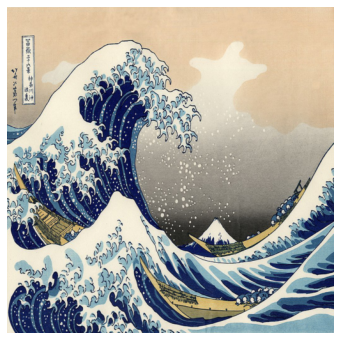

In [5]:
style_img = load_image('waves.jpg')
imshow(style_img)

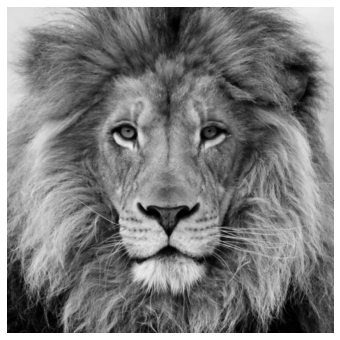

In [6]:
content_img = load_image('lion.jpg')
imshow(content_img)

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

In [0]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = self.gram_matrix(target).detach()

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

    def gram_matrix(self, tensor):
        B, C, H, W = tensor.shape
        x = tensor.view(C, H * W)
        G = torch.mm(x, x.t()).div(H * W)

        return G


In [0]:
class Normalization(nn.Module):
    def __init__(self, mean, std, device='cuda'):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, x):
        return (x - self.mean) / self.std

In [0]:
class Styler:
    def __init__(self, cnn, style_img, content_img,
                 style_layers=None, content_layers=None):
        if not style_layers:
            style_layers = ['relu_1', 'relu_2', 'relu_3', 'relu_4', 'relu_5']
        
        if not content_layers:
            content_layers = ['relu_4']

        self.model = self._build_model(cnn, style_img, content_img,
                                       style_layers, content_layers)
        
    def run_styling(self, input_img, lr=1e-3, num_steps=200,
                    style_weight=1e3, content_weight=1.):
        
        optimizer = optim.Adam([input_img], lr=lr)

        def get_losses():
            input_img.data.clamp_(0., 1.)
            optimizer.zero_grad()
            self.model(input_img)
            
            s_loss = 0
            for sl in self.style_losses:
                s_loss += sl.loss
            s_loss *= style_weight

            c_loss = 0
            for cl in self.content_losses:
                c_loss += cl.loss
            c_loss *= content_weight

            return s_loss, c_loss

        
        pbar = tqdm(range(num_steps), total=num_steps, leave=False, position=0)
        for step in pbar:
            s_loss, c_loss = get_losses()
            loss = s_loss + c_loss
            loss.backward(retain_graph=True)
            optimizer.step()

            pbar.set_description(
                'Style loss: {:.2f}, content loss: {:.2f}'.format(
                    s_loss.item(), c_loss.item()
                )
            )

        return torch.clamp(input_img.detach().cpu(), 0., 1.)

    def _build_model(self, cnn, style_img, content_img,
                     style_layers, content_layers):
        self.content_losses = []
        self.style_losses = []

        normalization = Normalization([0.485, 0.456, 0.406], 
                                      [0.229, 0.224, 0.225]).to(device)
        model = nn.Sequential(normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                layer_name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                layer_name = f'relu_{i}'
                layer = nn.ReLU()
            elif isinstance(layer, nn.MaxPool2d):
                layer_name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                layer_name = f'bn_{i}'

            model.add_module(layer_name, copy.deepcopy(layer))

            if layer_name in content_layers:
                target = model(content_img).detach()
                loss = ContentLoss(target)
                self.content_losses.append(loss)
                model.add_module(f'content_loss_{i}', loss)

            if layer_name in style_layers:
                target = model(style_img).detach()
                loss = StyleLoss(target)
                self.style_losses.append(loss)
                model.add_module(f'style_loss_{i}', loss)

        for i in reversed(range(len(model))):
            if isinstance(model[i], (StyleLoss, ContentLoss)):
                break

        return model[:(i + 1)]


In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [12]:
style_img = load_image('waves.jpg')
content_img = load_image('lion.jpg')
input_img = content_img.clone().detach().requires_grad_(True)

styler = Styler(cnn, style_img, content_img)
result_img = styler.run_styling(input_img, lr=1e-2, num_steps=4000,
                                style_weight=1e3, content_weight=1.)

In [0]:
collage = torch.cat(
    [content_img.cpu(), style_img.cpu(), result_img.cpu()],
    dim=-1
)

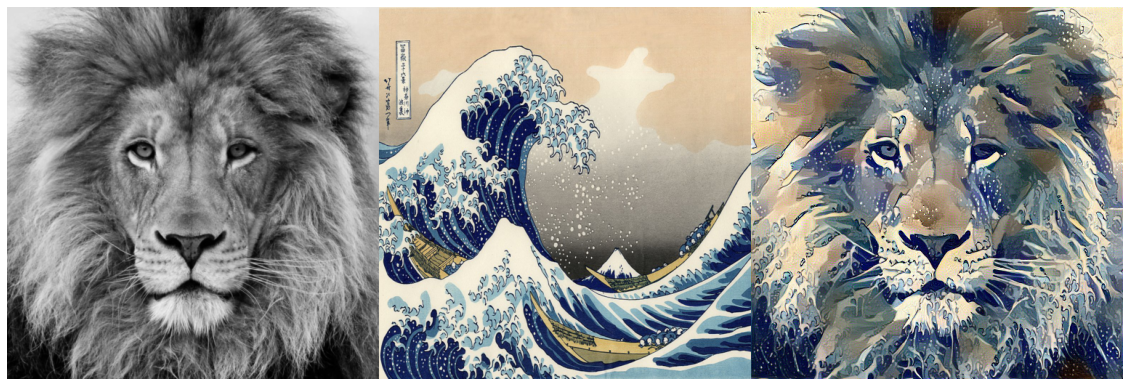

In [14]:
imshow(collage, (20, 20))